<a href="https://colab.research.google.com/github/gmmanzo/Seizure-Detection/blob/main/Seizure_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a seizure detection model using Time Series forecasting with the folllowing dataset https://physionet.org/content/chbmit/1.0.0/chb01/#files-panel

### To do this, we will first need to Extract and Visualize the Data to ensure the efficacy and reliability of the data,

Check for Recall(Main Part), Precision, F1 Score, & MAE in all of the model:

1. Naive Model, (Window = 7, Horizon = 1)
2. Basic Sequential Model (Window = 7, Horizon = 1)
3. Basic CNN (Window = 7, Horizon = 1)
4. Basic RNN (LSTM) (Window = 7, Horizon = 1)
5. Absolutely insane: Hybrid Model https://arxiv.org/html/2501.10342v1 (99.83% accuracy)

# Extract the data

In [1]:
pip install pyedflib

In [2]:
# Load all data
import pyedflib # Used for edf files
import pandas as pd

# Load the EDF file
file_path = "/content/PN00-1.edf"
edf = pyedflib.EdfReader(file_path, check_file_size=False)

# Extract signal labels
signal_labels = edf.getSignalLabels()

# Extract signal data
signals = []
for i in range(edf.signals_in_file):
    signals.append(edf.readSignal(i))

# Create a DataFrame
df = pd.DataFrame(signals).transpose()
df.columns = signal_labels

# Close the EDF file
edf.close()

# Display the DataFrame
print(df)




         EEG Fp1  EEG F3  EEG C3  EEG P3  EEG O1  EEG F7  EEG T3  EEG T5  \
0          1.875 -10.000  -0.875 -10.875  -5.625 -26.375   2.250   8.250   
1         -0.375 -12.500   0.500 -12.125 -14.375 -29.500  -3.500  -0.375   
2         -3.250 -12.500   1.750 -14.750 -24.125 -31.000  -5.125  -8.125   
3          0.375 -10.125   4.000 -13.250 -17.500 -28.500  -1.250  -1.750   
4          3.125  -7.250   3.875 -13.500 -18.625 -22.125   1.750  -2.250   
...          ...     ...     ...     ...     ...     ...     ...     ...   
1343995   -3.250  11.500   6.375   3.125  21.750  13.625  14.000  16.250   
1343996   10.375  13.125   9.125   4.750  24.875  16.750  13.750  19.000   
1343997   16.250  12.750  11.875   7.875  27.750  20.375  16.625  22.625   
1343998   13.250   9.250   9.750   5.375  20.250  19.375  15.625  19.250   
1343999    8.875   9.000   7.875   4.625  19.375  18.000  16.625  20.000   

         EEG Fc1  EEG Fc5  ...  EEG Fc6  EEG Cp2  EEG Cp6  EEG F10  \
0          0.625 

In [3]:
# Omit all columns except for EEG Fp1 and EEG Fp2
import pyedflib # Used for edf files
import pandas as pd
# Load the EDF file
import numpy as np

print("Available signals:", signal_labels)  # Debug

# Find indices of 'EEG Fp1' and 'EEG Fp2'
desired_labels = ['EEG Fp1', 'EEG Fp2']
indices = [i for i, label in enumerate(signal_labels) if label in desired_labels]

# Debug: Check indices found
print(f"EEG Fp1 Index: {indices[0] if len(indices) > 0 else 'Not Found'}")
print(f"EEG Fp2 Index: {indices[1] if len(indices) > 1 else 'Not Found'}")

# Ensure both channels exist
if len(indices) < 2:
    raise ValueError("EEG Fp1 or EEG Fp2 not found in the EDF file!")

# Extract only the required signals
signals_new = [edf.readSignal(i).flatten() for i in indices]

# Get sample rates
fs_fp1 = edf.getSampleFrequency(indices[0])
fs_fp2 = edf.getSampleFrequency(indices[1])

print(f"Sample Rate of EEG Fp1: {fs_fp1} Hz")
print(f"Sample Rate of EEG Fp2: {fs_fp2} Hz")

# If sample rates are different, print a warning
if fs_fp1 != fs_fp2:
    print("⚠️ Warning: EEG Fp1 and EEG Fp2 have different sample rates!")

#Generate time array based on first signal length
n_samples = len(signals_new[0])
time = np.arange(n_samples)/fs_fp1

# Create a DataFrame
df_new = pd.DataFrame(np.column_stack([time, signals_new[0], signals_new[1]]),
                      columns=['Time'] + desired_labels)
edf.close()

# Create a DataFrame without time array
#df_new = pd.DataFrame(signals_new).transpose()
#df_new.columns = desired_labels  # Keeping only EEG Fp1 and EEG Fp2

# Display the DataFrame
print(df_new)

Available signals: ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'MK']
EEG Fp1 Index: 0
EEG Fp2 Index: 16
read -1, less than 1344000 requested!!!
read -1, less than 1344000 requested!!!
Sample Rate of EEG Fp1: 512.0 Hz
Sample Rate of EEG Fp2: 512.0 Hz
                Time  EEG Fp1  EEG Fp2
0           0.000000      0.0      0.0
1           0.001953      0.0      0.0
2           0.003906      0.0      0.0
3           0.005859      0.0      0.0
4           0.007812      0.0      0.0
...              ...      ...      ...
1343995  2624.990234      0.0      0.0
1343996  2624.992188      0.0      0.0
1343997  2624.994141      0.0      0.0
1343998  2624.996094      0.0      0.0
1343999  2624.998047      0.

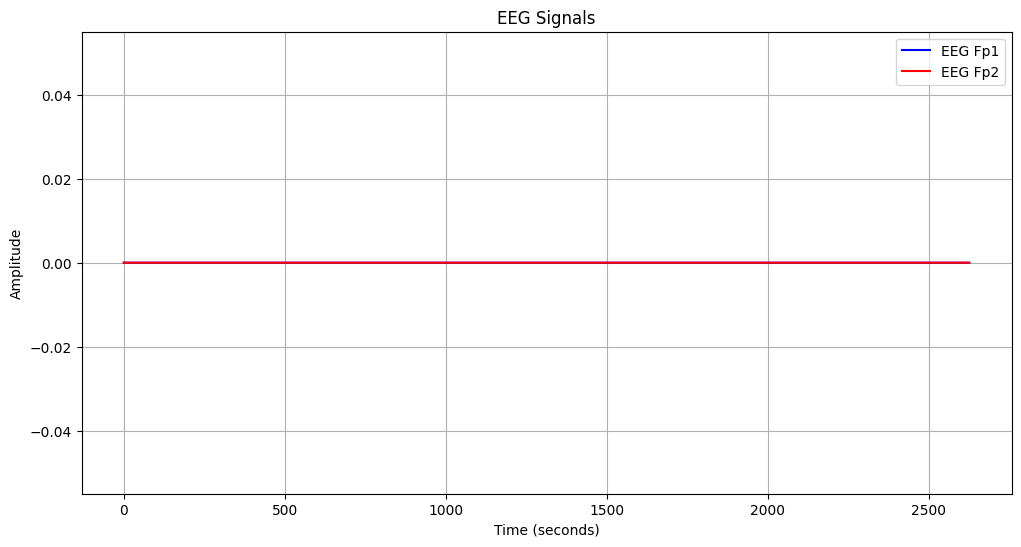

In [4]:
# Visualize data
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.plot(df_new['Time'], df_new['EEG Fp1'], label='EEG Fp1', color='blue')
plt.plot(df_new['Time'], df_new['EEG Fp2'], label='EEG Fp2', color='red')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('EEG Signals')
plt.legend()
plt.grid()
plt.show()

In [5]:
# checking signals data

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344000 entries, 0 to 1343999
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Time     1344000 non-null  float64
 1   EEG Fp1  1344000 non-null  float64
 2   EEG Fp2  1344000 non-null  float64
dtypes: float64(3)
memory usage: 30.8 MB


## Feature extraction and Seizure classification:

1. Understand EEG format, look at data frame using "name.head()"
2. Choose machine learning task
* EEG classification: detecting seizures
* EEG regression: predicting cognitive load
* EEG time series analysis: forecasting (LSTM, CNNs)
3. Feature engineering to extract features like:
* Statistical Features: Mean, variance, skewness, kurtosis
* Frequency Features: Power spectral density (PSD), Fast Fourier Transform (FFT)
* Wavelet Features: Decomposition of EEG signals
* Time-Series Features: Moving averages, peak detection
4. Format for machine learning
5. Train ML model
6. Evaluate and optimize

**Sliding windows**: split EEG data into smaller structured segments that overlap based on step size to ensure smooth transitions. Different window sizes can help capture short term or long term patterns

In [12]:
#Load data
import pyedflib
import numpy as np
import pandas as pd


#Extract signal labels and check
EEG_labels = edf.getSignalLabels()
print("EEG labels:", EEG_labels)

EEG labels: ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'MK']


In [7]:
# Segment Data into Windows
# This is useful when there is a lot of data
window_size = 512 #number of samples per second
step_size = 50 #overlap between windows

# Create sliding windows
def create_windows(eeg_data, window_size, step_size):
    windows = [eeg_data[i:i+window_size] for i in range(0, len(eeg_data) - window_size + 1, step_size)]
    return np.array(windows)

# Apply sliding window to each channel signal
sliding_windows = {}
for i, label in enumerate(EEG_labels):
    channel_signal = signals[i]
    sliding_windows[label] = create_windows(channel_signal, window_size, step_size)

In [8]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Define feature extraction function (Import this into our github helper functions)
def extract_features(windows):
    """
    Extracts features from a list of windows. The features include:
    1. Mean
    2. Standard Deviation
    3. Skewness
    4. Kurtosis
    5. Power Spectral Density (PSD)
    """
    features = {}

    # Time-domain features
    features['mean'] = np.mean(windows)
    features['std'] = np.std(windows)
    features['skew'] = skew(windows)
    features['kurtosis'] = kurtosis(windows)

    # Frequency-domain features (Power Spectral Density)
    f, Pxx = welch(windows, fs=512, nperseg=512)
    features['power_band'] = np.sum(Pxx)  # Total power

    return features

# Extract features for each window in each channel
features = []
for label, windows in sliding_windows.items():
    for window in windows:
        features.append(extract_features(windows))

# Convert feature list to a DataFrame
df_features = pd.DataFrame(features)

# Display the first few rows of the extracted features
print(df_features.head())



KeyboardInterrupt: 

# Extract Electrode points:
F7,
Fp1,
Fp2,
F8,
T3,
T4,
T5,
T6

In [9]:
#print(df['EEG Fp1']), print(df['EEG Fp2']), print(df['EEG F7']), print(df['EEG F8']), print(df['EEG T3']), print(df['EEG T4']), print(df['EEG T5']), print(df['EEG T6'])
df_extracted = df[['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG T5', 'EEG T6']]

In [10]:
df_extracted

,EEG Fp1,EEG Fp2,EEG F7,EEG F8,EEG T3,EEG T4,EEG T5,EEG T6
0,1.875,1.125,-26.375,-22.625,2.250,-10.625,8.250,-8.375
1,-0.375,-0.625,-29.500,-25.250,-3.500,-8.500,-0.375,-3.250
2,-3.250,-3.500,-31.000,-24.500,-5.125,-1.125,-8.125,2.500
3,0.375,-0.875,-28.500,-24.625,-1.250,-2.375,-1.750,0.375
4,3.125,5.125,-22.125,-18.000,1.750,-4.375,-2.250,-3.875
...,...,...,...,...,...,...,...,...
1343995,-3.250,4.625,13.625,8.375,14.000,22.625,16.250,23.125
1343996,10.375,1.875,16.750,6.000,13.750,23.875,19.000,17.500
1343997,16.250,-3.250,20.375,3.125,16.625,21.375,22.625,3.625
1343998,13.250,-8.500,19.375,0.375,15.625,11.250,19.250,-3.375


Text(0.5, 1.0, 'EEG Fp1 and EEG Fp2 Electrodes raw signals')

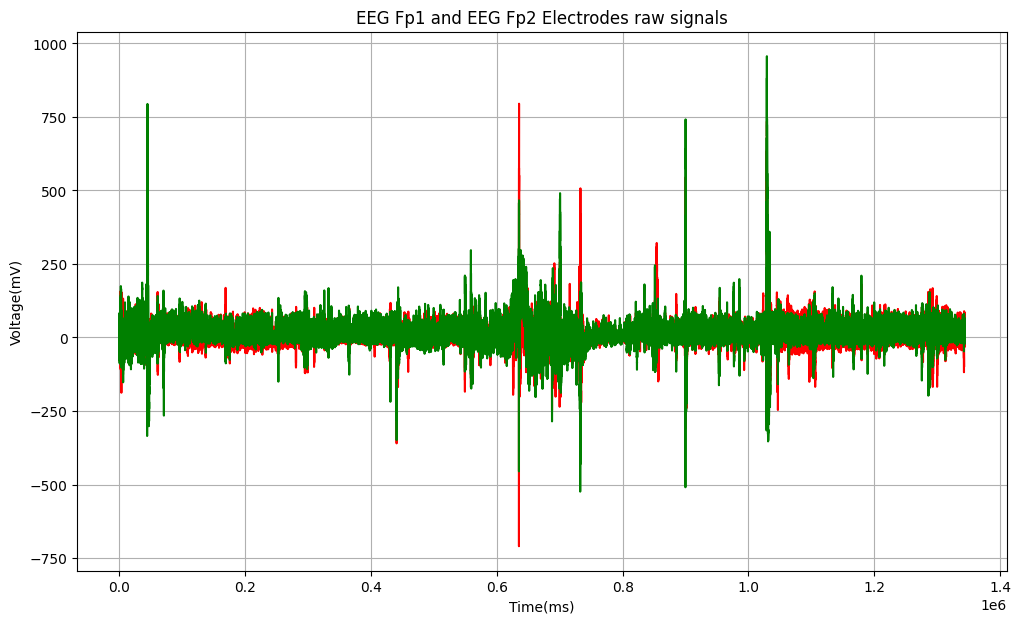

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12,7))
EEG_Fp1 = df_extracted['EEG Fp1']
EEG_Fp2 = df_extracted['EEG Fp2']
plt.plot(EEG_Fp1, color="red")
plt.plot(EEG_Fp2, color="green")
plt.grid()
plt.xlabel('Time(ms)')
plt.ylabel('Voltage(mV)')
plt.title("EEG Fp1 and EEG Fp2 Electrodes raw signals")

Text(0.5, 1.0, '1D FFT of EEG_Fp1 data')

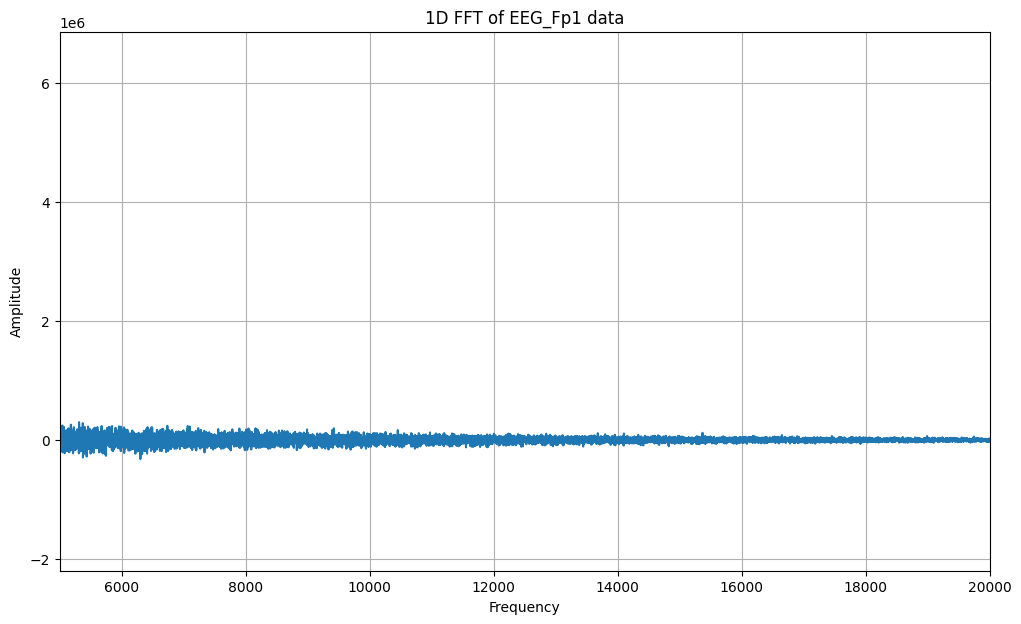

In [44]:
# 1D Discrete Fast Fourier Transform Version of data:
from scipy.fft import fft, fftfreq, rfft
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

fft_data2 = tf.signal.rfft(tf.cast(EEG_Fp1, tf.float32)) # Need to convert the data type into a 64 bit to run the FFT function

plt.figure(figsize = (12,7))
plt.plot(fft_data2)
plt.xlim(5000,20000)
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title("1D FFT of EEG_Fp1 data")

In [49]:
def edf_file_extractor(file_path):
  """
  Opens an EDF file and returns its contents in the form of a Data Frame
  """
  # Load all data
  import pyedflib # Used for edf files
  import pandas as pd

  # Load the EDF file
  edf = pyedflib.EdfReader(file_path, check_file_size=False)

  # Extract signal labels
  signal_labels = edf.getSignalLabels()

  # Extract signal data
  signals = []
  for i in range(edf.signals_in_file):
      signals.append(edf.readSignal(i))

  # Create a DataFrame
  df = pd.DataFrame(signals).transpose()
  df.columns = signal_labels

  # Close the EDF file
  edf.close()

  return df

In [50]:
edf_file_extractor(file_path)

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8
0,-187.350427,90.842491,72.087912,-60.366300,-68.571429,-14.652015,0.976801,-2.539683,-83.028083,-95.140415,...,-32.625153,-39.658120,24.029304,-77.948718,21.294261,-71.697192,-65.054945,93.186813,-3.711844,-39.658120
1,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
2,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
3,0.586081,-0.586081,0.195360,-0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,...,0.586081,-0.195360,0.195360,0.195360,0.195360,0.195360,0.976801,-0.195360,0.195360,-0.195360
4,-0.195360,0.195360,0.195360,0.586081,-0.195360,0.195360,0.195360,0.586081,0.195360,0.195360,...,-0.586081,0.586081,0.195360,0.195360,0.195360,0.195360,-0.586081,0.586081,0.195360,0.586081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921595,25.982906,-32.234432,-5.274725,-30.671551,-28.717949,-52.942613,45.909646,-5.274725,-30.280830,-5.274725,...,15.042735,18.168498,6.446886,8.009768,3.321123,5.665446,-42.783883,13.870574,-48.644689,18.168498
921596,34.188034,-21.684982,-4.102564,-38.485958,-28.327228,-24.810745,50.989011,-27.155067,-23.638584,-0.586081,...,24.810745,-12.307692,1.367521,12.698413,6.056166,4.493284,-34.969475,5.665446,-10.354090,-12.307692
921597,38.876679,21.684982,-25.201465,-40.830281,-22.075702,9.181929,36.141636,-27.545788,-3.711844,7.619048,...,21.294261,-37.704518,16.996337,10.354090,8.009768,25.592186,-50.207570,-65.836386,67.789988,-37.704518
921598,34.969475,50.207570,-40.048840,-41.221001,-10.354090,18.168498,30.671551,-33.797314,-7.228327,13.870574,...,-21.684982,3.321123,33.406593,11.135531,13.479853,40.439560,-36.923077,-147.887668,66.227106,3.321123
